In [ ]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.model_runner import evaluate_models, plot_predicted_vs_true, plot_regression_metrics, plot_residuals
from src.utils.preprocess import GeneExpPreprocessor
from src.utils.data_handler import DataHandler

DH = DataHandler()

Current working directory: /home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load GE and PFS</h1>

In [ ]:
GEP = GeneExpPreprocessor(auto_preprocess=False)
GEP._load_expr()
GEP._log1p_tpm_normalization()
all_exp = GEP.get_df()

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
pfs = metadata['Progress Free Survival (Months)']

n_patients = all_exp.index.get_level_values("patient_id").nunique()
n_samples = all_exp.index.get_level_values("sample_id").nunique()
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
There are 1018 patients and 1132 samples in the dataset.


<h1>Align indices for df_exp and PFS</h2>

In [ ]:
df_exp = all_exp.copy()

def truncate_sample_id(s):
    parts = s.split('-')
    if len(parts) >= 4:
        return '-'.join(parts[:4])[:-1]
    else:
        return s

new_index = df_exp.index.set_levels(
    df_exp.index.levels[1].map(truncate_sample_id),
    level=1
)

df_exp.index = new_index

<h1>Generate X and y</h1>

In [4]:
X = df_exp.copy()

# remove samples with nan pfs values
pfs = pfs.dropna()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(pfs.index)

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
pfs = pfs.loc[intersection_samples]
y = list(pfs)

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [ ]:
def filter_data(X: pd.DataFrame, y: list[float]) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.
    """
    X = DH.filter_by_mean(X, 1)
    X = DH.filter_by_variance(X, 100)
    return X, X.columns.to_list()

results = evaluate_models(X, y, filter_data=filter_data)

<h1>plot data</h1>

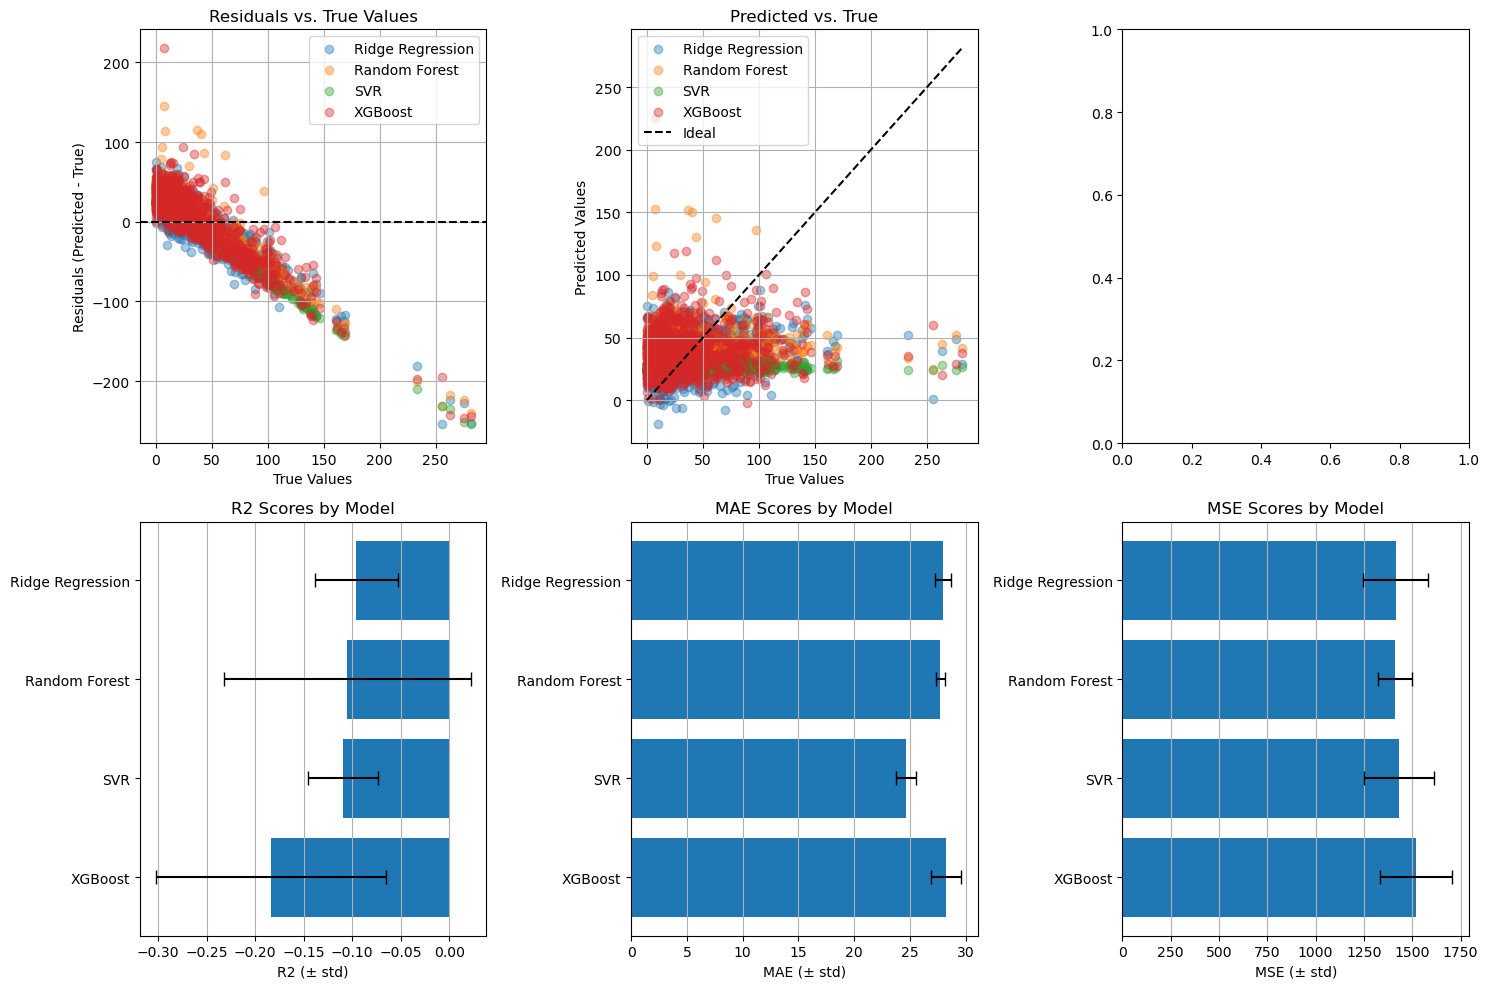

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_residuals(results, ax=axes[0, 0])
plot_predicted_vs_true(results, ax=axes[0, 1])
plot_regression_metrics(results, ax=axes[1,0], metric='R2')
plot_regression_metrics(results, ax=axes[1,1], metric='MAE')
plot_regression_metrics(results, ax=axes[1,2], metric='MSE')

fig.tight_layout()